<a href="https://colab.research.google.com/github/dcpatton/ragged_tensors/blob/main/ragged_imdb_test.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf
import random
import numpy as np

seed=52
tf.random.set_seed(seed)
random.seed(seed)
np.random.seed(seed)

vocab_size=10000

tf.__version__

'2.3.0'

# Padded to longest review length

In [2]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.imdb.load_data(num_words=vocab_size, seed=seed)

17465344/17464789 [==============================] - 1s 0us/step


In [3]:
# A couple of examples
index = tf.keras.datasets.imdb.get_word_index()
reverse_index = dict([(value, key) for (key, value) in index.items()]) 
decoded = " ".join( [reverse_index.get(i - 3, "#") for i in x_train[0]] )
print(decoded) 
print(y_train[0])

decoded = " ".join( [reverse_index.get(i - 3, "#") for i in x_train[2]] )
print(decoded)
print(y_train[2])

1646592/1641221 [==============================] - 0s 0us/step
# a must see i saw whipped at a press screening and it was hilarious we're talking # laughs it makes something about mary seem like a meandering drama amanda # screams star quality with her winning combination of beauty brains and serious acting ability peter cohen the director has made a cutting edge film that shows the raw inside of men's # in the urban dating world for all of it's comedy whipped succeeds with it's intelligence which is so rare for a first time director especially with a romantic comedy he is a major talent # # brian van holt jonathan # and # # round out the cast with depth and very strong performances as the would be slick # men you've got to see these guys go to work and get caught in # web check out the trailer on whipped com it's worth the 3 minute #
1
# phantom of the mall is a film that fits best in the easily forgotten category it's a pretty lousy # on the famous story by # # the phantom of the ope

In [4]:
maxlen = 0
for i in range(x_train.shape[0]):
  if len(x_train[i]) > maxlen:
    maxlen = len(x_train[i])

maxlen

2494

In [5]:
x_train = tf.keras.preprocessing.sequence.pad_sequences(x_train, maxlen=maxlen, padding='post')
x_test = tf.keras.preprocessing.sequence.pad_sequences(x_test, maxlen=maxlen, padding='post')

In [6]:
tf.keras.backend.clear_session()
from tensorflow.keras.layers import Embedding, LSTM, Dense, Bidirectional
from tensorflow.keras import Input, Model

input1 = Input(shape=(maxlen,))
x = Embedding(vocab_size, 64)(input1)
x = LSTM(64)(x)
out = Dense(1, activation='sigmoid')(x)

model = Model(inputs=[input1], outputs=[out])
model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 2494)]            0         
_________________________________________________________________
embedding (Embedding)        (None, 2494, 64)          640000    
_________________________________________________________________
lstm (LSTM)                  (None, 64)                33024     
_________________________________________________________________
dense (Dense)                (None, 1)                 65        
Total params: 673,089
Trainable params: 673,089
Non-trainable params: 0
_________________________________________________________________


In [7]:
model.compile(optimizer='adam', loss='bce', metrics=['acc'])

filepath = 'model.h5'

mc = tf.keras.callbacks.ModelCheckpoint(filepath, verbose=0, save_weights_only=True, 
                                        monitor='val_loss', mode='auto', save_best_only=True)

es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, verbose=1, mode='auto')


In [8]:
%%time
history = model.fit(x_train, y_train, epochs=100, batch_size=16, 
                    validation_data=(x_test, y_test), callbacks=[mc, es])

Epoch 1/100
1563/1563 [==============================] - 174s 111ms/step - loss: 0.6934 - acc: 0.4994 - val_loss: 0.6933 - val_acc: 0.5000
Epoch 2/100
1563/1563 [==============================] - 173s 111ms/step - loss: 0.6932 - acc: 0.4990 - val_loss: 0.6932 - val_acc: 0.5000
Epoch 3/100
1563/1563 [==============================] - 174s 111ms/step - loss: 0.6933 - acc: 0.4946 - val_loss: 0.6932 - val_acc: 0.5000
Epoch 4/100
1563/1563 [==============================] - 175s 112ms/step - loss: 0.6932 - acc: 0.4993 - val_loss: 0.6932 - val_acc: 0.5000
Epoch 5/100
1563/1563 [==============================] - 174s 112ms/step - loss: 0.6934 - acc: 0.4982 - val_loss: 0.6932 - val_acc: 0.5000
Epoch 6/100
1563/1563 [==============================] - 175s 112ms/step - loss: 0.6932 - acc: 0.4987 - val_loss: 0.6932 - val_acc: 0.5000
Epoch 7/100
1563/1563 [==============================] - 175s 112ms/step - loss: 0.6932 - acc: 0.4982 - val_loss: 0.6932 - val_acc: 0.5000
Epoch 8/100
1563/1563 [====

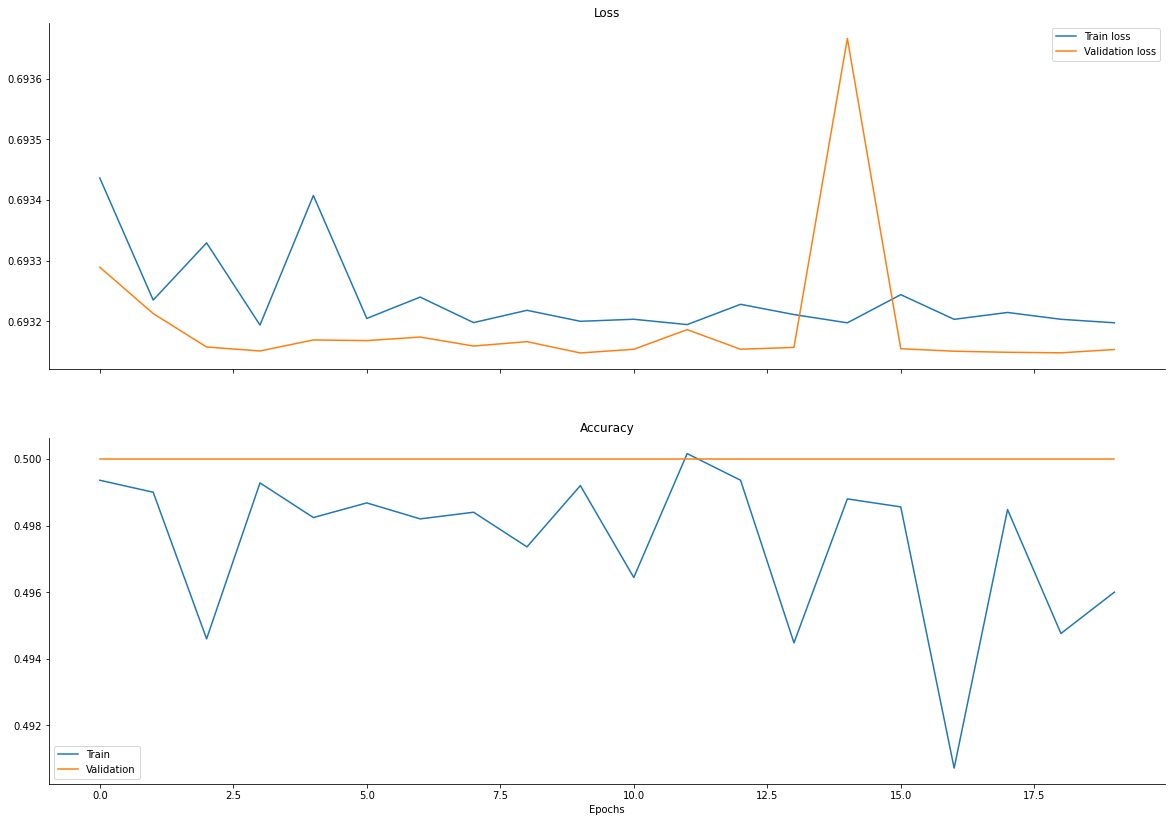

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns

history = history.history

fig, (ax1, ax2) = plt.subplots(2, 1, sharex='col', figsize=(20, 14))

ax1.plot(history['loss'], label='Train loss')
ax1.plot(history['val_loss'], label='Validation loss')
ax1.legend(loc='best')
ax1.set_title('Loss')

ax2.plot(history['acc'], label='Train')
ax2.plot(history['val_acc'], label='Validation')
ax2.legend(loc='best')
ax2.set_title('Accuracy')

plt.xlabel('Epochs')
sns.despine()
plt.show()

In [10]:
model.load_weights('model.h5')
model.evaluate(x_test, y_test)

782/782 [==============================] - 34s 44ms/step - loss: 0.6931 - acc: 0.5000


[0.6931478381156921, 0.5]

# Padded to the average review length

In [11]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.imdb.load_data(num_words=vocab_size, seed=seed)

In [12]:
total = 0
for i in range(x_train.shape[0]):
  total += len(x_train[i])

maxlen = int(total/x_train.shape[0])
maxlen

238

In [13]:
x_train = tf.keras.preprocessing.sequence.pad_sequences(x_train, maxlen=maxlen, padding='post')
x_test = tf.keras.preprocessing.sequence.pad_sequences(x_test, maxlen=maxlen, padding='post')

In [14]:
tf.keras.backend.clear_session()
from tensorflow.keras.layers import Embedding, LSTM, Dense, Bidirectional
from tensorflow.keras import Input, Model

input1 = Input(shape=(maxlen,))
x = Embedding(vocab_size, 64)(input1)
x = LSTM(64)(x)
out = Dense(1, activation='sigmoid')(x)

model = Model(inputs=[input1], outputs=[out])
model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 238)]             0         
_________________________________________________________________
embedding (Embedding)        (None, 238, 64)           640000    
_________________________________________________________________
lstm (LSTM)                  (None, 64)                33024     
_________________________________________________________________
dense (Dense)                (None, 1)                 65        
Total params: 673,089
Trainable params: 673,089
Non-trainable params: 0
_________________________________________________________________


In [15]:
model.compile(optimizer='adam', loss='bce', metrics=['acc'])

filepath = 'model.h5'

mc = tf.keras.callbacks.ModelCheckpoint(filepath, verbose=0, save_weights_only=True, 
                                        monitor='val_loss', mode='auto', save_best_only=True)

es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, verbose=1, mode='auto')

In [16]:
%%time
history = model.fit(x_train, y_train, epochs=100, batch_size=16, 
                    validation_data=(x_test, y_test), callbacks=[mc, es])

Epoch 1/100
1563/1563 [==============================] - 36s 23ms/step - loss: 0.6641 - acc: 0.5685 - val_loss: 0.6510 - val_acc: 0.5698
Epoch 2/100
1563/1563 [==============================] - 35s 23ms/step - loss: 0.6218 - acc: 0.6146 - val_loss: 0.6455 - val_acc: 0.5770
Epoch 3/100
1563/1563 [==============================] - 34s 22ms/step - loss: 0.5386 - acc: 0.7238 - val_loss: 0.5786 - val_acc: 0.7422
Epoch 4/100
1563/1563 [==============================] - 34s 22ms/step - loss: 0.5190 - acc: 0.7364 - val_loss: 0.5419 - val_acc: 0.7665
Epoch 5/100
1563/1563 [==============================] - 34s 22ms/step - loss: 0.2952 - acc: 0.8830 - val_loss: 0.3174 - val_acc: 0.8716
Epoch 6/100
1563/1563 [==============================] - 34s 22ms/step - loss: 0.1950 - acc: 0.9286 - val_loss: 0.3149 - val_acc: 0.8789
Epoch 7/100
1563/1563 [==============================] - 34s 22ms/step - loss: 0.1401 - acc: 0.9525 - val_loss: 0.3728 - val_acc: 0.8739
Epoch 8/100
1563/1563 [==================

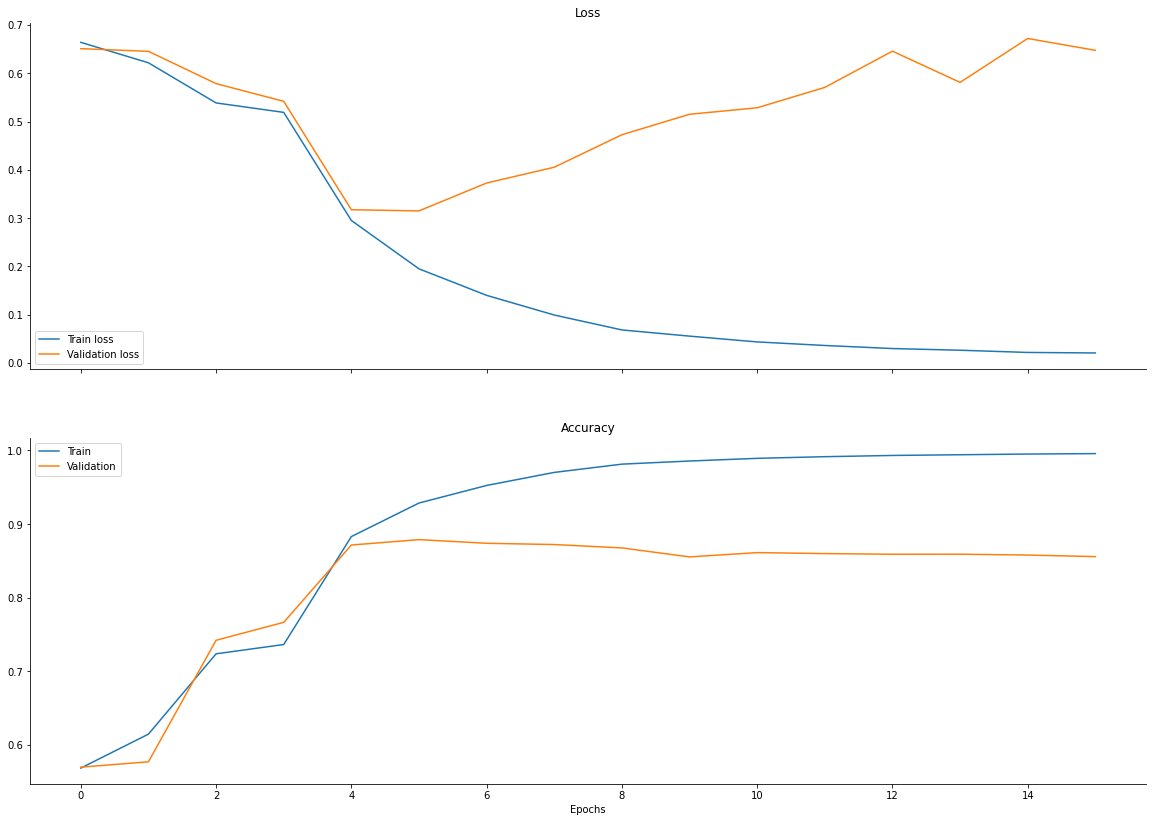

In [17]:
history = history.history

fig, (ax1, ax2) = plt.subplots(2, 1, sharex='col', figsize=(20, 14))

ax1.plot(history['loss'], label='Train loss')
ax1.plot(history['val_loss'], label='Validation loss')
ax1.legend(loc='best')
ax1.set_title('Loss')

ax2.plot(history['acc'], label='Train')
ax2.plot(history['val_acc'], label='Validation')
ax2.legend(loc='best')
ax2.set_title('Accuracy')

plt.xlabel('Epochs')
sns.despine()
plt.show()

In [18]:
model.load_weights('model.h5')
model.evaluate(x_test, y_test)

782/782 [==============================] - 5s 6ms/step - loss: 0.3149 - acc: 0.8789


[0.31494393944740295, 0.8788800239562988]

# Ragged

In [19]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.imdb.load_data(num_words=vocab_size, seed=seed)

In [20]:
r_train_x = tf.ragged.constant(x_train)
r_test_x = tf.ragged.constant(x_test)

In [21]:
tf.keras.backend.clear_session()
from tensorflow.keras.layers import Embedding, LSTM, Dense, Bidirectional
from tensorflow.keras import Input, Model

input1 = Input(shape=(None,), ragged=True)
x = Embedding(vocab_size, 64)(input1)
x = LSTM(64)(x)
out = Dense(1, activation='sigmoid')(x)

model = Model(inputs=[input1], outputs=[out])
model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, None)]            0         
_________________________________________________________________
embedding (Embedding)        (None, None, 64)          640000    
_________________________________________________________________
lstm (LSTM)                  (None, 64)                33024     
_________________________________________________________________
dense (Dense)                (None, 1)                 65        
Total params: 673,089
Trainable params: 673,089
Non-trainable params: 0
_________________________________________________________________


In [22]:
model.compile(optimizer='adam', loss='bce', metrics=['acc'])

filepath = 'model.h5'

mc = tf.keras.callbacks.ModelCheckpoint(filepath, verbose=0, save_weights_only=True, 
                                        monitor='val_loss', mode='auto', save_best_only=True)

es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, verbose=1, mode='auto')


In [23]:
%%time
history = model.fit(r_train_x, y_train, epochs=100, batch_size=16, 
                    validation_data=(r_test_x, y_test), callbacks=[mc, es])

Epoch 1/100


/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/indexed_slices.py:432: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


1563/1563 [==============================] - 2104s 1s/step - loss: 0.5829 - acc: 0.6917 - val_loss: 0.5354 - val_acc: 0.7191
Epoch 2/100
1563/1563 [==============================] - 2095s 1s/step - loss: 0.4299 - acc: 0.8036 - val_loss: 0.6087 - val_acc: 0.6766
Epoch 3/100
1563/1563 [==============================] - 2099s 1s/step - loss: 0.2746 - acc: 0.8913 - val_loss: 0.3020 - val_acc: 0.8740
Epoch 4/100
1563/1563 [==============================] - 2118s 1s/step - loss: 0.1729 - acc: 0.9352 - val_loss: 0.2931 - val_acc: 0.8842
Epoch 5/100
1563/1563 [==============================] - 2112s 1s/step - loss: 0.1201 - acc: 0.9582 - val_loss: 0.3682 - val_acc: 0.8729
Epoch 6/100
1563/1563 [==============================] - 2114s 1s/step - loss: 0.1031 - acc: 0.9639 - val_loss: 0.3777 - val_acc: 0.8735
Epoch 7/100
1563/1563 [==============================] - 2114s 1s/step - loss: 0.0663 - acc: 0.9795 - val_loss: 0.4096 - val_acc: 0.8718
Epoch 8/100
1563/1563 [==============================

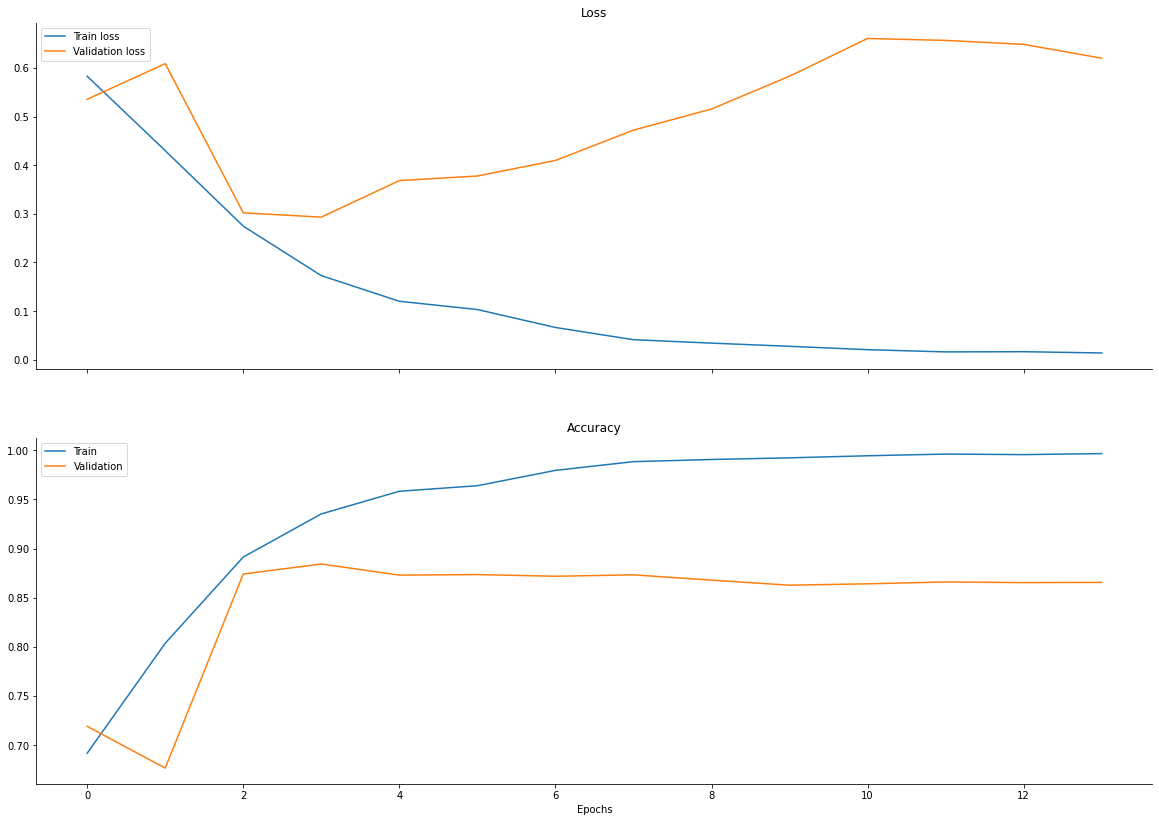

In [24]:
history = history.history

fig, (ax1, ax2) = plt.subplots(2, 1, sharex='col', figsize=(20, 14))

ax1.plot(history['loss'], label='Train loss')
ax1.plot(history['val_loss'], label='Validation loss')
ax1.legend(loc='best')
ax1.set_title('Loss')

ax2.plot(history['acc'], label='Train')
ax2.plot(history['val_acc'], label='Validation')
ax2.legend(loc='best')
ax2.set_title('Accuracy')

plt.xlabel('Epochs')
sns.despine()
plt.show()

In [25]:
model.load_weights('model.h5')
model.evaluate(r_test_x, y_test)

782/782 [==============================] - 167s 213ms/step - loss: 0.2931 - acc: 0.8842


[0.29314124584198, 0.8841999769210815]